In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#OS libs
import os
import shutil
import itertools
import pathlib
from PIL import Image

#Data handling tools
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

#Deep learning libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

#Warningds
import warnings
warnings.filterwarnings('ignore')

#combine dataset

In [4]:
train_data_path = "/content/drive/MyDrive/lab ai stuff/dataset/dataset/Training"

filepaths = []
labels = []

folds = os.listdir(train_data_path)

for fold in folds:
  f_path = os.path.join(train_data_path, fold)
  if os.path.isdir(f_path):
    filelists = os.listdir(f_path)
    for file in filelists:
      filepaths.append(os.path.join(f_path, file))
      labels.append(fold)

#concat data path with labels
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='label')
train_df = pd.concat([Fseries, Lseries], axis = 1)

In [5]:
train_df

,filepaths,label
0,/content/drive/MyDrive/lab ai stuff/dataset/da...,pituitary
1,/content/drive/MyDrive/lab ai stuff/dataset/da...,pituitary
2,/content/drive/MyDrive/lab ai stuff/dataset/da...,pituitary
3,/content/drive/MyDrive/lab ai stuff/dataset/da...,pituitary
4,/content/drive/MyDrive/lab ai stuff/dataset/da...,pituitary
...,...,...
5707,/content/drive/MyDrive/lab ai stuff/dataset/da...,meningioma
5708,/content/drive/MyDrive/lab ai stuff/dataset/da...,meningioma
5709,/content/drive/MyDrive/lab ai stuff/dataset/da...,meningioma
5710,/content/drive/MyDrive/lab ai stuff/dataset/da...,meningioma


In [6]:
test_data_path = "/content/drive/MyDrive/lab ai stuff/dataset/dataset/Testing"

filepaths = []
labels = []

folds = os.listdir(test_data_path)

for fold in folds:
  f_path = os.path.join(test_data_path, fold)
  if os.path.isdir(f_path):
    filelists = os.listdir(f_path)
    for file in filelists:
      filepaths.append(os.path.join(f_path, file))
      labels.append(fold)

#concat data path with labels
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='label')
test_df = pd.concat([Fseries, Lseries], axis = 1)


In [7]:
test_df

,filepaths,label
0,/content/drive/MyDrive/lab ai stuff/dataset/da...,pituitary
1,/content/drive/MyDrive/lab ai stuff/dataset/da...,pituitary
2,/content/drive/MyDrive/lab ai stuff/dataset/da...,pituitary
3,/content/drive/MyDrive/lab ai stuff/dataset/da...,pituitary
4,/content/drive/MyDrive/lab ai stuff/dataset/da...,pituitary
...,...,...
1306,/content/drive/MyDrive/lab ai stuff/dataset/da...,meningioma
1307,/content/drive/MyDrive/lab ai stuff/dataset/da...,meningioma
1308,/content/drive/MyDrive/lab ai stuff/dataset/da...,meningioma
1309,/content/drive/MyDrive/lab ai stuff/dataset/da...,meningioma


#data spltting

In [8]:
valid , test = train_test_split(test_df, train_size= 0.5, shuffle = True, random_state = 42)

In [9]:
img_size = (224 ,244)
batch_size = 16

tr_gen = ImageDataGenerator()
ts_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test , x_col= 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


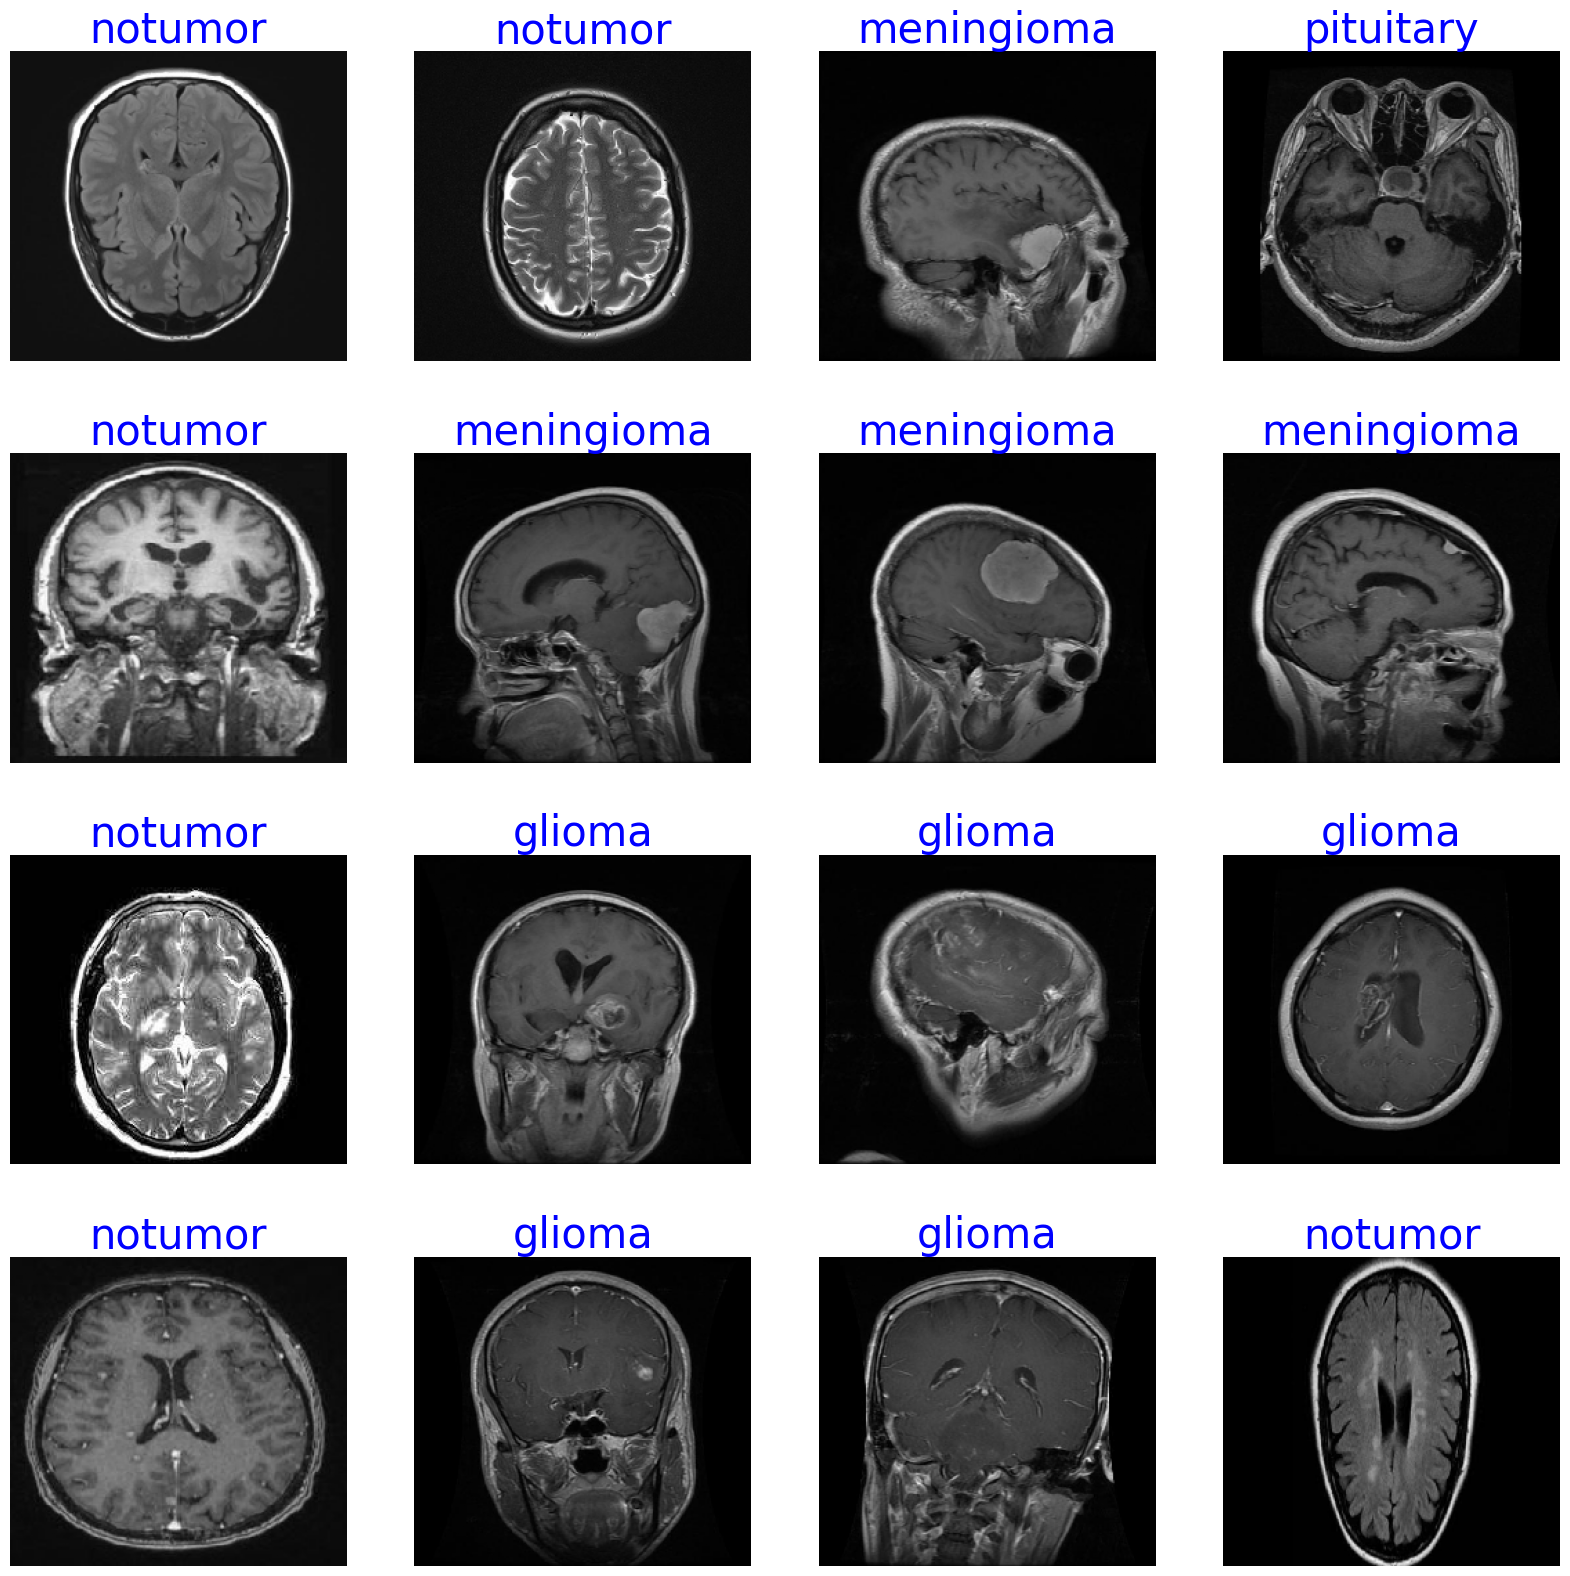

In [10]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
  plt.subplot(4,4,i+1)
  image = images[i]/ 255
  plt.imshow(image)
  index = np.argmax(labels[i])
  class_name = classes[index]
  plt.title(class_name, color= "blue", fontsize = 30)
  plt.axis('off')
plt.show();

In [11]:
img_shape = (img_size[0] , img_size[1] , 3)
num_class = len(classes)

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top = False , weights = 'imagenet',
    input_shape = img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1 , momentum= 0.99 , epsilon= 0.001),
    Dense(256, kernel_regularizer = regularizers.l2(0.016) , activity_regularizer = regularizers.l1(0.006),
         bias_regularizer= regularizers.l1(0.006) , activation = 'relu'),
    Dropout(rate= 0.4 , seed = 75),
    Dense(num_class , activation = 'softmax')
])

model.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,253,396 (23.85 MB)

 Trainable params: 6,190,228 (23.61 MB)

 Non-trainable params: 63,168 (246.75 KB)

#traning

In [12]:
from IPython.core import history
Epochs = 10

history = model.fit(
    train_gen,
    epochs= Epochs,
    verbose=1,
    validation_data= valid_gen,
    shuffle= True,
)

Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 950s 2s/step - accuracy: 0.5163 - loss: 10.0143 - val_accuracy: 0.3679 - val_loss: 5.6589
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 39s 110ms/step - accuracy: 0.3425 - loss: 5.1798 - val_accuracy: 0.3710 - val_loss: 3.8755
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 39s 109ms/step - accuracy: 0.3593 - loss: 3.5536 - val_accuracy: 0.5145 - val_loss: 2.6864
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 39s 109ms/step - accuracy: 0.5243 - loss: 2.5094 - val_accuracy: 0.5252 - val_loss: 1.9606
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 38s 107ms/step - accuracy: 0.6444 - loss: 1.8591 - val_accuracy: 0.8641 - val_loss: 1.3780
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 41s 107ms/step - accuracy: 0.8546 - loss: 1.3523 - val_accuracy: 0.9496 - val_loss: 0.9864
Epoch 7/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 38s 105ms/step - accuracy: 0.9021 - loss: 1.0462 - val_accuracy: 0.9740 - val_loss: 0.7514
Epoch 8/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 39s 108ms/step - accuracy: 0.9238 - loss: 0.

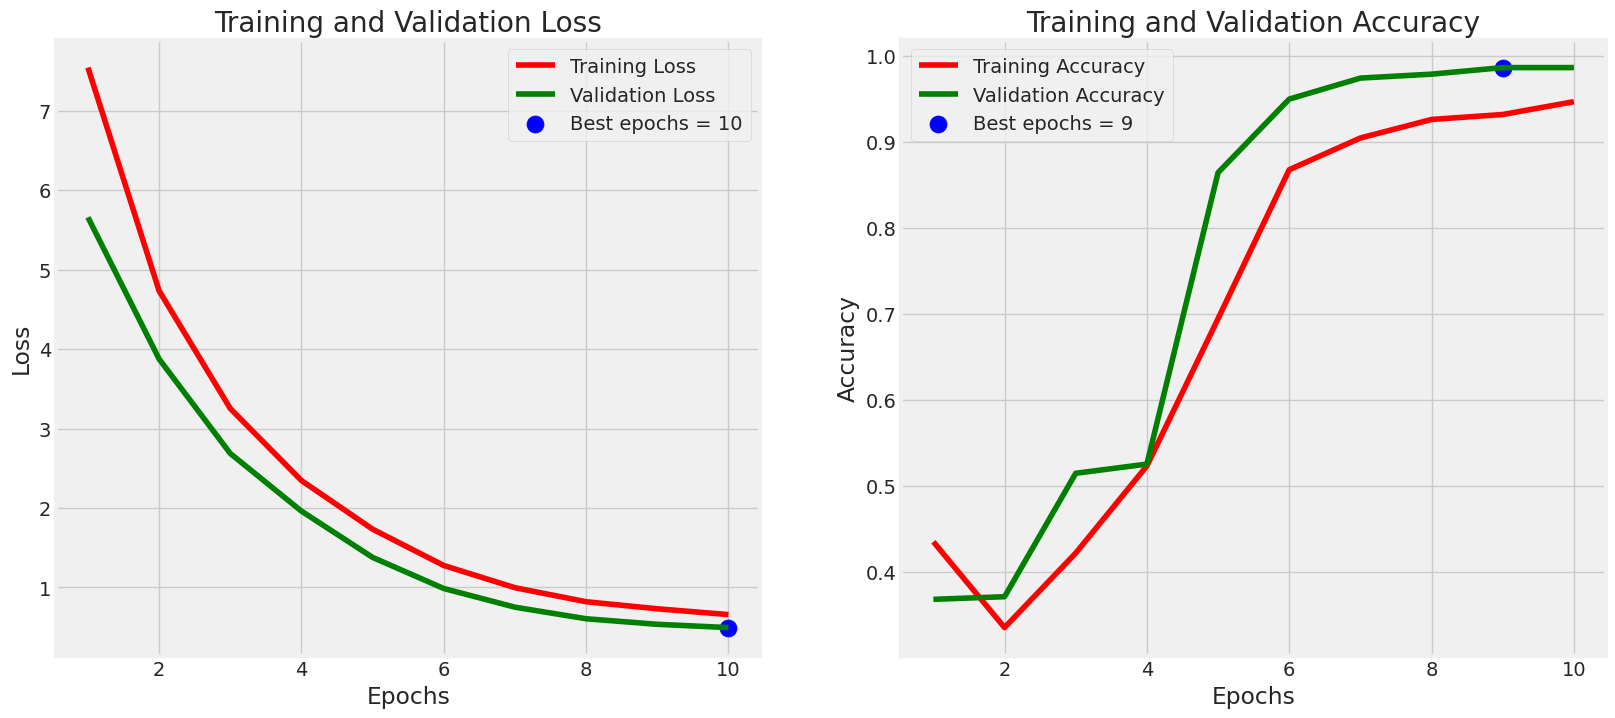

In [13]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

#Training history

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

In [13]:
train_score = model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

In [14]:
preds = model.predict(test_gen)

y_pred = np.argmax(preds , axis = 1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 183s 4s/step


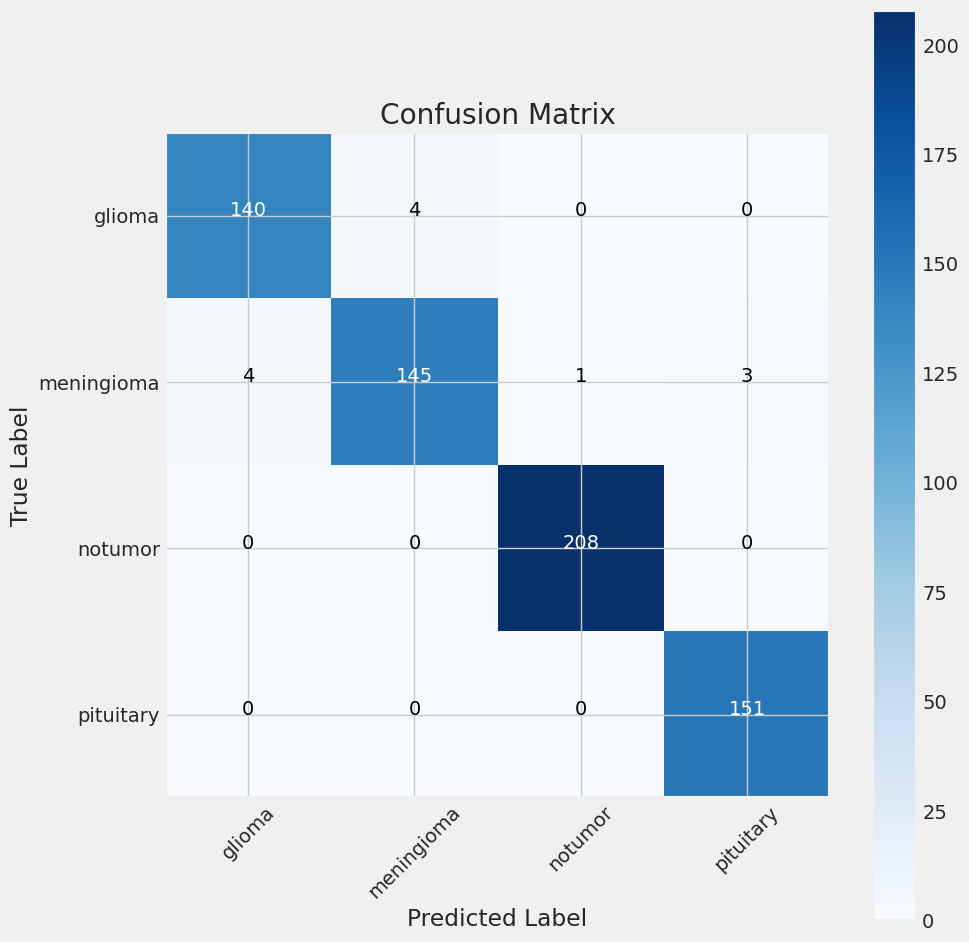

In [15]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [16]:
#Classification Report
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

      glioma       0.97      0.97      0.97       144
  meningioma       0.97      0.95      0.96       153
     notumor       1.00      1.00      1.00       208
   pituitary       0.98      1.00      0.99       151

    accuracy                           0.98       656
   macro avg       0.98      0.98      0.98       656
weighted avg       0.98      0.98      0.98       656



In [17]:
model.save("model.h5")

In [18]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

In [19]:
model = load_model('model.h5', compile=False)
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [21]:
gambar = tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/lab ai stuff/dataset/dataset/Testing/glioma/Te-glTr_0000.jpg', target_size=img_size)

In [22]:
input_arr = tf.keras.preprocessing.image.img_to_array(gambar)

In [23]:
input_arr = np.array([input_arr])
prediksi = model.predict(input_arr)
predicted_class = np.argmax(prediksi, axis=-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


In [24]:
print(classes)

['glioma', 'meningioma', 'notumor', 'pituitary']


In [25]:
print(predicted_class)

[0]


In [26]:
names = [classes[i] for i in predicted_class]
print(names)

['glioma']
